<a href="https://colab.research.google.com/github/Akshiitha/MediScan/blob/main/MediScan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define dataset path
dataset_path = '/content/drive/My Drive/MediScan/archive (1)/dataset'

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Dataset Parameters
dataset_path = '/content/drive/My Drive/MediScan/archive (1)/dataset'  # Update this to your dataset path
img_height, img_width = 224, 224
batch_size = 32
epochs = 10

In [ ]:

# Step 1: Data Preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Train and validation data loaders
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

Found 3404 images belonging to 4 classes.
Found 848 images belonging to 4 classes.


In [ ]:
# Compute class weights (for imbalanced datasets)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# Step 2: Define the Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the base model initially

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Replace Flatten with GAP for better transfer learning
    Dropout(0.5),  # Regularization to prevent overfitting
    Dense(128, activation='relu'),
    Dense(train_data.num_classes, activation='softmax')  # Match number of classes
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile the Model (Initial Training)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#Train the Model
initial_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,  # Initial training with frozen base
    steps_per_epoch=train_data.samples // batch_size,
    validation_steps=val_data.samples // batch_size,
    class_weight=class_weights_dict
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 1017s 9s/step - accuracy: 0.6445 - loss: 0.9247 - val_accuracy: 0.7115 - val_loss: 0.6940
Epoch 2/5
  1/106 ━━━━━━━━━━━━━━━━━━━━ 11:20 6s/step - accuracy: 0.7812 - loss: 0.5283

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7812 - loss: 0.5283 - val_accuracy: 0.7500 - val_loss: 0.5144
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 875s 8s/step - accuracy: 0.8177 - loss: 0.4624 - val_accuracy: 0.7380 - val_loss: 0.6619
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8438 - loss: 0.4309 - val_accuracy: 0.8125 - val_loss: 0.4875
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 841s 8s/step - accuracy: 0.8234 - loss: 0.4617 - val_accuracy: 0.7464 - val_loss: 0.6352


In [ ]:
# Step 3: Fine-Tuning
# Unfreeze the base model layers
base_model.trainable = True

# Set a learning rate scheduler
def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.1

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Compile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Continue training (Fine-Tuning)
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,  # Additional fine-tuning epochs
    steps_per_epoch=train_data.samples // batch_size,
    validation_steps=val_data.samples // batch_size,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler]
)


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3157s 29s/step - accuracy: 0.6527 - loss: 1.2650 - val_accuracy: 0.7284 - val_loss: 0.7376 - learning_rate: 1.0000e-05
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 92s 598ms/step - accuracy: 0.7812 - loss: 0.4415 - val_accuracy: 0.6875 - val_loss: 0.6608 - learning_rate: 1.0000e-05
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3066s 29s/step - accuracy: 0.8442 - loss: 0.4298 - val_accuracy: 0.7740 - val_loss: 0.5944 - learning_rate: 1.0000e-05
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.8750 - loss: 0.1762 - val_accuracy: 0.4375 - val_loss: 0.9912 - learning_rate: 1.0000e-05
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3095s 29s/step - accuracy: 0.8764 - loss: 0.3276 - val_accuracy: 0.7668 - val_loss: 0.6165 - learning_rate: 1.0000e-05
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.9375 - loss: 0.2030 - val_accuracy: 0.7500 - val_loss: 0.7115 - learning_rate: 1.0000e-06
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3044s 29

In [ ]:
# Step 4: Visualize Training Performance
import matplotlib.pyplot as plt

In [ ]:
# Combine histories
history = {
    'accuracy': initial_history.history['accuracy'] + fine_tune_history.history['accuracy'],
    'val_accuracy': initial_history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'],
    'loss': initial_history.history['loss'] + fine_tune_history.history['loss'],
    'val_loss': initial_history.history['val_loss'] + fine_tune_history.history['val_loss']
}



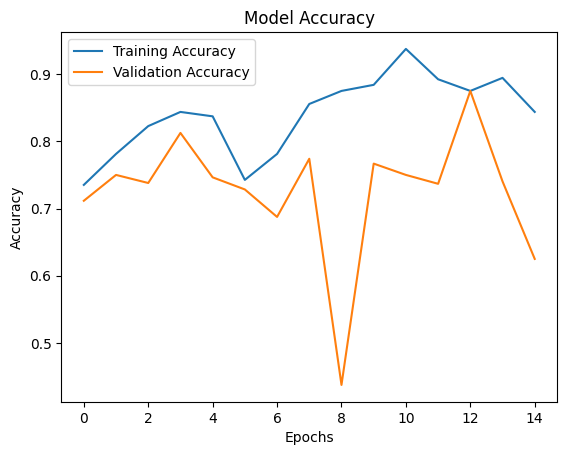

In [ ]:
# Plot training vs validation accuracy
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()



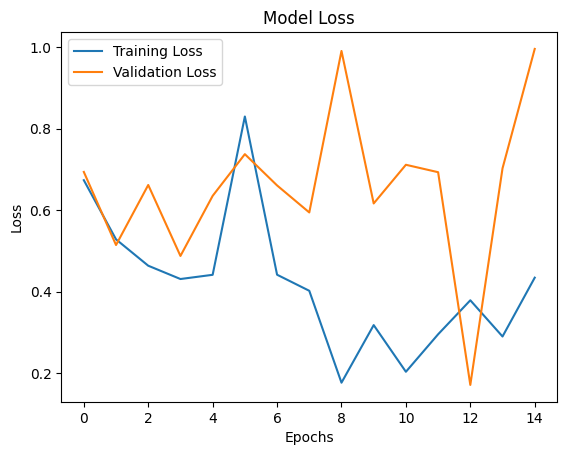

In [ ]:
# Plot training vs validation loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()